In this Homework, you will make a question answering bot using using Transformers.

TODO:
1. Tokenize the data and create a vocabulary using [sentencepiece](https://github.com/google/sentencepiece/blob/master/python/README.md). Set `vocab_size=1000, pad_id=0, unk_id=1, bos_id=2, eos_id=3`. After making the tokenization model encode your data and don't forget to add <sos\> and <eos\>.
2. Pad your source and target data.
3. Split the data into 80:20 train and test set.
4. Create and train your own encorder-decoder transformer architecture using pytorch/tensorflow.
6. Evaluate your models on test data and calculate the [bleu score](https://machinelearningmastery.com/calculate-bleu-score-for-text-python/).
7. Show some example questions, true answers and generated answers from the test data.
8. Ask it some questions of your own and show how how it answers.


In [2]:
!wget https://qnamakerstore.blob.core.windows.net/qnamakerdata/editorial/english/qna_chitchat_professional.tsv

--2024-08-02 09:25:50--  https://qnamakerstore.blob.core.windows.net/qnamakerdata/editorial/english/qna_chitchat_professional.tsv
Resolving qnamakerstore.blob.core.windows.net (qnamakerstore.blob.core.windows.net)... 20.60.81.165
Connecting to qnamakerstore.blob.core.windows.net (qnamakerstore.blob.core.windows.net)|20.60.81.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 981694 (959K) [text/plain]
Saving to: 'qna_chitchat_professional.tsv'

qna_chitchat_profes 100%[===================>] 958.69K  1.85MB/s    in 0.5s    

2024-08-02 09:25:51 (1.85 MB/s) - 'qna_chitchat_professional.tsv' saved [981694/981694]



In [3]:
import pandas as pd
pd.read_csv("qna_chitchat_professional.tsv", sep="\t")[["Question", "Answer"]].to_csv("qna_chitchat_professional.tsv", index=False, sep="\t")

In [4]:
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils

In [5]:
df = pd.read_csv("qna_chitchat_professional.tsv", sep="\t")[["Question", "Answer"]]

In [6]:
df

,Question,Answer
0,Do you get hurt?,I don't have a body.
1,Do you have fingers?,I don't have a body.
2,Do you ever breathe,I don't have a body.
3,Do you masticate?,I don't have a body.
4,Can you throw up?,I don't have a body.
...,...,...
9788,I'm tired from work,I hope you're able to get some rest soon.
9789,I'm totally drained,I hope you're able to get some rest soon.
9790,I'm totally exhausted,I hope you're able to get some rest soon.
9791,Zzzzz,I hope you're able to get some rest soon.


## Tokenize

In [7]:
import sentencepiece as spm

In [8]:
text_data = np.array(df)

with open('text_data.txt', 'w', encoding='utf-8') as f:
    for lines in text_data:
        for line in lines:
            f.write(f"{line}\n")

In [9]:
spm.SentencePieceTrainer.train(input='text_data.txt', model_prefix='m', vocab_size=1000, pad_id=0, unk_id=1, bos_id=2, eos_id=3)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: text_data.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 1000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 3
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential

In [10]:
sp = spm.SentencePieceProcessor(model_file='m.model')

In [11]:
sos_id = sp.piece_to_id('<s>')
eos_id = sp.piece_to_id('</s>')

tokenized_data = []
for texts in text_data:
    tokenized_data.append([[sos_id] + sp.encode(texts[0]) + [eos_id], [sos_id] + sp.encode(texts[1]) + [eos_id]])

print(f"Original: {text_data[0]}")
print(f"Tokenized: {tokenized_data[0]}")

Original: ['Do you get hurt?' "I don't have a body."]
Tokenized: [[2, 39, 7, 61, 516, 12, 3], [2, 5, 18, 6, 10, 17, 14, 289, 4, 3]]


In [12]:
max_len = max([len(text) for data in tokenized_data for text in data])
max_len

46

In [13]:
def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
    return padded

In [14]:
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence

In [15]:
tokenized_data = [[pad_sequences(data[0], max_len), pad_sequences(data[1], max_len)] for data in tokenized_data]
tokenized_data[0]

[array([  2,  39,   7,  61, 516,  12,   3,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0]),
 array([  2,   5,  18,   6,  10,  17,  14, 289,   4,   3,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0])]

In [16]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(tokenized_data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
train_data[0]

[array([  2,  39,   7, 316,  71,  76, 309,  55,  12,   3,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0]),
 array([  2,   5,  18,   6,  10,  17,  14, 289,   4,   3,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0])]

In [17]:
from torch.utils.data import DataLoader, Dataset

class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]

In [18]:
train_set = MyDataset(train_data)
val_set = MyDataset(val_data)
test_set = MyDataset(test_data)

In [19]:
BATCH_SIZE = 32

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, shuffle=False)

## Encoder

In [113]:
def generate_src_mask(src):
    pad_token_id = sp.piece_to_id('<pad>')    
    return src != pad_token_id


def generate_tgt_mask(tgt_seq, num_heads):
    pad_token_id = sp.piece_to_id('<pad>')
    batch_size, tgt_len = tgt_seq.size()
    
    # Create mask to mark positions of non-padding tokens
    tgt_pad_mask = (tgt_seq != pad_token_id).unsqueeze(1)
    # Shape: (batch_size, 1, tgt_len)
    
    # Create causal mask to prevent attending to future tokens
    tgt_subsequent_mask = torch.tril(torch.ones((tgt_len, tgt_len), dtype=torch.bool)).unsqueeze(0)
    # Shape: (1, tgt_len, tgt_len)
    
    # Combine padding and causal masks
    tgt_mask = tgt_pad_mask.to(tgt_seq.device) & tgt_subsequent_mask.to(tgt_seq.device)
    # Shape: (batch_size, tgt_len, tgt_len)
    
    # Repeat the mask for each head and reshape
    tgt_mask = tgt_mask.repeat(num_heads, 1, 1)
    # Shape: (batch_size * num_heads, tgt_len, tgt_len)
    
    tgt_mask = torch.where(tgt_mask, torch.tensor(1.0), torch.tensor(float('-inf')))
#     print(tgt_mask)
    
    return tgt_mask

In [114]:
import math

class PositionalEmbedding(nn.Module):
    def __init__(self, embed_dim, max_len=512):
        super(PositionalEmbedding, self).__init__()
        self.pos_embedding = nn.Embedding(max_len, embed_dim)

    def forward(self, x):
        seq_len = x.size(1)
        pos = torch.arange(0, seq_len, dtype=torch.long, device=x.device).unsqueeze(0)
        pos = pos.expand(x.size(0), seq_len)
#         print('pos', pos.shape)
        pos_embed = self.pos_embedding(pos)
#         print('pos_embed', pos_embed.shape)
#         print('x', x.shape)
        return x + pos_embed

In [115]:
class EncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_hidden, dropout=0.1):
        super(EncoderLayer, self).__init__()
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.fc1 = nn.Linear(embed_dim, ff_hidden)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(ff_hidden, embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        
    def forward(self, x, src_mask=None):
        attention, _ = self.attention(x, x, x, key_padding_mask=src_mask)
        x = self.norm1(x + self.dropout(attention))
        
        ff_out = self.fc2(self.dropout(self.gelu(self.fc1(x))))
        x = self.norm2(x + self.dropout(ff_out))
        
        return x

In [116]:
class BERT(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_hidden, num_layers, dropout=0.1):
        super(BERT, self).__init__()
                
        self.positional_embed = PositionalEmbedding(embed_dim)
        self.encoder_layers = nn.ModuleList([EncoderLayer(embed_dim, num_heads, ff_hidden, dropout) for _ in range(num_layers)])
        
    def forward(self, x, src_mask=None):
        x = self.positional_embed(x)
        for layer in self.encoder_layers:
            x = layer(x, src_mask)
        return x

## Decoder

In [117]:
class DecoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_hidden, dropout=0.1):
        super(DecoderLayer, self).__init__()
        
        self.embed_dim = embed_dim
        self.ff_hidden = ff_hidden
        
        self.attention1 = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True, dropout=dropout)
        self.attention2 = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.norm3 = nn.LayerNorm(embed_dim)
        
        self.fc1 = nn.Linear(embed_dim, ff_hidden)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(ff_hidden, embed_dim)
        
    def forward(self, x, enc_out, tgt_mask=None, src_mask=None):    
        attn1, _ = self.attention1(x, x, x, attn_mask=tgt_mask)
        x = self.norm1(x + self.dropout(attn1))
        
        attn2, _ = self.attention2(x, enc_out, enc_out, key_padding_mask=src_mask)
        x = self.norm2(x + self.dropout(attn2))
                
        ff_out = self.fc2(self.dropout(self.gelu(self.fc1(x))))
        x = self.norm3(x + self.dropout(ff_out))
        
        return x

In [118]:
class TransformerDecoder(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_hidden, num_layers, vocab_size, max_len=5000, dropout=0.1):
        super(TransformerDecoder, self).__init__()
        
        self.pos_embed = PositionalEmbedding(embed_dim, max_len)
        self.decoder_layers = nn.ModuleList([DecoderLayer(embed_dim, num_heads, ff_hidden, dropout) for _ in range(num_layers)])
        self.fc = nn.Linear(embed_dim, vocab_size)
        
    def forward(self, x, enc_out, tgt_mask=None, src_mask=None):
        x = self.pos_embed(x)
        for layer in self.decoder_layers:
            x = layer(x, enc_out, tgt_mask, src_mask)
        x = self.fc(x)
        return x

## Combine Both Models

In [119]:
class Transformer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_hidden, num_layers_enc, num_layers_dec, vocab_size, dropout=0.1):
        super(Transformer, self).__init__()
        
        self.num_heads = num_heads
        
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        self.encoder = BERT(embed_dim, num_heads, ff_hidden, num_layers_enc, dropout=dropout)
        self.decoder = TransformerDecoder(embed_dim, num_heads, ff_hidden, num_layers_dec, vocab_size, dropout=dropout)
        
    def forward(self, question, answer):
        src_mask = generate_src_mask(question).to(question.device)
        tgt_mask = generate_tgt_mask(answer, self.num_heads).to(answer.device)
                        
        question = self.embedding(question)
        answer = self.embedding(answer)
                
        encoded = self.encoder(question, src_mask)
        
        out = self.decoder(answer, encoded, tgt_mask=tgt_mask, src_mask=src_mask)
        
        return out
    
    def answer(self, questions, max_length=50):
        device = questions.device
        src_mask = generate_src_mask(questions).to(device)
        questions = self.embedding(questions)
#         print(questions.shape)

        batch_size = questions.shape[0]
        with torch.no_grad():
            encoded = self.encoder(questions)

            start_token = torch.full((batch_size, 1), sp.piece_to_id('<s>'), dtype=torch.long, device=device)
            generated_answers = start_token

            for _ in range(max_length):
                embedded_answers = self.embedding(generated_answers)
                outputs = self.decoder(embedded_answers, encoded, src_mask=src_mask)
                predicted = outputs.argmax(2)[:, -1:]
                generated_answers = torch.cat([generated_answers, predicted], dim=1)
                
                if (predicted == sp.piece_to_id('</s>')).all():
                    break

            generated_answers = generated_answers[:, 1:] 
            end_positions = (generated_answers == sp.piece_to_id('</s>')).float().argmax(1)
            
            decoded_answers = []
            for i, end_pos in enumerate(end_positions):
                if end_pos == 0:
                    answer = generated_answers[i].tolist()
                else:
                    answer = generated_answers[i, :end_pos].tolist()
                decoded_answers.append(sp.decode_ids(answer))

        return decoded_answers

## Training

In [120]:
def train(model, criterion, optimizer, num_epochs=50):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_training_loss = 0
        
        for questions, answers in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]'):
            questions = questions.to(device)
            answers = answers.type(torch.long).to(device)
            
            outputs = model(questions, answers[:, :-1])
            
            loss = criterion(outputs.reshape(-1, outputs.shape[2]), answers[:, 1:].reshape(-1))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_training_loss += loss.item()
        
        avg_train_loss = running_training_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        running_val_loss = 0
        
        with torch.no_grad():
            for questions, answers in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]'):
                questions = questions.to(device)
                answers = answers.type(torch.long).to(device)
                
                outputs = model(questions, answers[:, :-1])
                
                loss = criterion(outputs.reshape(-1, outputs.shape[2]), answers[:, 1:].reshape(-1))
                running_val_loss += loss.item()
        
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f'\nEpoch: {epoch+1}/{num_epochs}, Training loss: {avg_train_loss:.4f}, Validation loss: {avg_val_loss:.4f}')
    
    return train_losses, val_losses

In [121]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [137]:
embed_dim = 256
num_heads = 4
ff_hidden = 512
num_layers_enc = 5
num_layers_dec = 5
vocab_size = sp.vocab_size()
dropout = 0.2


model = Transformer(embed_dim, num_heads, ff_hidden, num_layers_enc, num_layers_dec, vocab_size, dropout).to(device)
model = nn.DataParallel(model, device_ids=[0, 1]).to(device)

In [138]:
criterion = nn.CrossEntropyLoss(ignore_index=sp.piece_to_id('<pad>'))
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [139]:
train_losses, val_losses = train(model, criterion, optimizer, num_epochs=10)

Epoch 1/10 [Val]: 100%|██████████| 49/49 [00:01<00:00, 27.76it/s]



Epoch: 1/10, Training loss: 1.8030, Validation loss: 0.5012


Epoch 2/10 [Val]: 100%|██████████| 49/49 [00:01<00:00, 27.92it/s]



Epoch: 2/10, Training loss: 0.5092, Validation loss: 0.4414


Epoch 3/10 [Val]: 100%|██████████| 49/49 [00:02<00:00, 23.81it/s]



Epoch: 3/10, Training loss: 0.4609, Validation loss: 0.4295


Epoch 4/10 [Val]: 100%|██████████| 49/49 [00:01<00:00, 30.85it/s]



Epoch: 4/10, Training loss: 0.4439, Validation loss: 0.4138


Epoch 5/10 [Val]: 100%|██████████| 49/49 [00:01<00:00, 28.91it/s]



Epoch: 5/10, Training loss: 0.4336, Validation loss: 0.4119


Epoch 6/10 [Val]: 100%|██████████| 49/49 [00:01<00:00, 30.41it/s]



Epoch: 6/10, Training loss: 0.4286, Validation loss: 0.4156


Epoch 7/10 [Val]: 100%|██████████| 49/49 [00:01<00:00, 28.81it/s]



Epoch: 7/10, Training loss: 0.4259, Validation loss: 0.4079


Epoch 8/10 [Val]: 100%|██████████| 49/49 [00:01<00:00, 30.39it/s]



Epoch: 8/10, Training loss: 0.4221, Validation loss: 0.4081


Epoch 9/10 [Val]: 100%|██████████| 49/49 [00:01<00:00, 30.49it/s]



Epoch: 9/10, Training loss: 0.4184, Validation loss: 0.4062


Epoch 10/10 [Val]: 100%|██████████| 49/49 [00:01<00:00, 25.05it/s]


Epoch: 10/10, Training loss: 0.4161, Validation loss: 0.4047


In [149]:
train_losses_cont, val_losses_cont = train(model, criterion, optimizer, num_epochs=10)
train_losses += train_losses_cont
val_losses += val_losses_cont

Epoch 1/10 [Val]: 100%|██████████| 49/49 [00:01<00:00, 29.75it/s]



Epoch: 1/10, Training loss: 0.4152, Validation loss: 0.4113


Epoch 2/10 [Val]: 100%|██████████| 49/49 [00:01<00:00, 30.24it/s]



Epoch: 2/10, Training loss: 0.4161, Validation loss: 0.4067


Epoch 3/10 [Val]: 100%|██████████| 49/49 [00:01<00:00, 30.08it/s]



Epoch: 3/10, Training loss: 0.4125, Validation loss: 0.4105


Epoch 4/10 [Val]: 100%|██████████| 49/49 [00:01<00:00, 29.64it/s]



Epoch: 4/10, Training loss: 0.4125, Validation loss: 0.4063


Epoch 5/10 [Val]: 100%|██████████| 49/49 [00:01<00:00, 30.23it/s]



Epoch: 5/10, Training loss: 0.4126, Validation loss: 0.4060


Epoch 6/10 [Val]: 100%|██████████| 49/49 [00:01<00:00, 30.38it/s]



Epoch: 6/10, Training loss: 0.4098, Validation loss: 0.4035


Epoch 7/10 [Val]: 100%|██████████| 49/49 [00:01<00:00, 30.44it/s]



Epoch: 7/10, Training loss: 0.4110, Validation loss: 0.4013


Epoch 8/10 [Val]: 100%|██████████| 49/49 [00:01<00:00, 29.23it/s]



Epoch: 8/10, Training loss: 0.4094, Validation loss: 0.4062


Epoch 9/10 [Val]: 100%|██████████| 49/49 [00:01<00:00, 30.19it/s]



Epoch: 9/10, Training loss: 0.4087, Validation loss: 0.4067


Epoch 10/10 [Val]: 100%|██████████| 49/49 [00:01<00:00, 29.49it/s]


Epoch: 10/10, Training loss: 0.4071, Validation loss: 0.4052


In [140]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.legend(['Train', 'Validation'])
    plt.show()

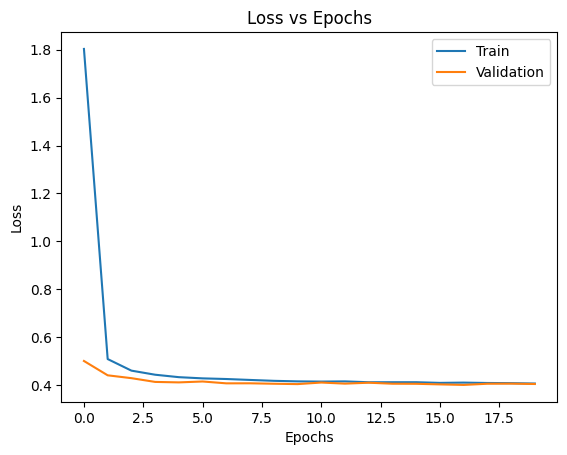

In [156]:
start_idx = 
plot_losses(train_losses[start_idx:], val_losses[start_idx:])

## Bleu Score

In [151]:
from nltk.translate.bleu_score import corpus_bleu

test_loader = DataLoader(test_set, batch_size=128)

generated_captions = []
reference_captions = []

model.eval()
with torch.no_grad():
    for question, answer in tqdm(test_loader):
        question = question.to(device)

        generated_answers = model.module.answer(question, max_length=50)
        answer = sp.decode_ids(answer.cpu().tolist())
        
        generated_captions += generated_answers
        reference_captions += answer

# print(generated_captions)

bleu_score = corpus_bleu(reference_captions, generated_captions)
print("BLEU Score:", bleu_score)

100%|██████████| 16/16 [00:07<00:00,  2.23it/s]


BLEU Score: 0.7880964742193423


## Examples

In [152]:
import random

for _ in range(5):
    question, answer = random.choice(test_set)
    model.eval()
    with torch.no_grad():
        question = torch.tensor(question).to(device).unsqueeze(0)
        question = question.to(device)

        generated_answer = model.module.answer(question, max_length=50)
        generate_answer = ' '.join(generated_answer)
        answer = ''.join(sp.decode_ids(answer.tolist()))
        question = ' '.join(sp.decode_ids(question.cpu().tolist()))
        
        print(f'Question: {question}\nReference Answer: {answer}\nGenerated Answer: {generated_answer[0]}\n')

Question: Do you know any other chatbots?
Reference Answer: I've heard of other bots, but I haven't met any.
Generated Answer: That's not me, but hello.

Question: I hate feeling sad
Reference Answer: I'm very sorry to hear that.
Generated Answer: That's not me, but hello.

Question: Please ask me anything about me
Reference Answer: I'm better at answering questions.
Generated Answer: That's not me, but hello.

Question: You're happy today.
Reference Answer: I'm quite happy, thank you.
Generated Answer: That's not me, but hello.

Question: I'm furious
Reference Answer: Sorry to hear that.
Generated Answer: That's not me, but hello.

